# Hero Demo - Wind Shear

In [1]:
%matplotlib inline
import intake
import iris
import datetime
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import holoviews as hv
import geoviews as gv
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
# hv.extension('bokeh')

/opt/conda/lib/python3.6/site-packages/intake/source/discovery.py:39: UserWarning: Plugin name collision for "netcdf" from
    /opt/conda/lib/python3.6/site-packages/intake_iris/netcdf.py
and
    /opt/conda/lib/python3.6/site-packages/intake_xarray/netcdf.py
Keeping plugin from first location.
  % (plugin_name, orig_path, new_path))


## Guidence on wind shear for aviation in the UK
We're expecting high shear conditions over the UK this week. This analysis will identify risk regions and issue shear warning accoringly.

In [2]:
direction = intake.cat.mo_aws_earth.mogreps_g.wind_from_direction_at_pressure.read()
speed = intake.cat.mo_aws_earth.mogreps_g.wind_speed_at_pressure.read()

KeyError: 'mo_aws_earth'

In [34]:
def boundry_presure_levels(cube):
    upper = cube.extract(
                iris.Constraint(
                    pressure=lambda p:p < cube.coord('pressure').points[0]))
    lower = cube.extract(
                    iris.Constraint(
                        pressure=lambda p:p > cube.coord('pressure').points[-1]))
    
    new_levels = (upper.coord('pressure').points +  lower.coord('pressure').points )/2
    for cube in [upper, lower]:
        cube.coord('pressure').points = new_levels
        cube.coord('pressure').bounds = None
    return upper, lower

def calculate_shear(wind_speed, wind_dir):
    # Calculate the cross-product of wind vectors between consecutive pressure levels
    
    # lets ensure we are working on the same coords on both cubes
    assert wind_speed.coord_dims('pressure') == wind_dir.coord_dims('pressure')
    
    # make copies of cubes
    speed = wind_speed.copy()
    direction = wind_dir.copy()
    
    # work out the parameters for the 
    speed_lower, speed_upper = boundry_presure_levels(speed)
    dir_lower, dir_upper = boundry_presure_levels(direction)
    
    dir_diff = dir_lower - dir_upper
    sin_dir_diff = iris.analysis.maths.apply_ufunc(np.sin, dir_diff)
    
    # calculate the cross-product
    shear = speed_lower * speed_upper * sin_dir_diff
    
    # rename cube and add units
    shear.long_name = "Wind Shear"
    shear.units = "m2 s-2"
    
    return shear

In [29]:
# ask henry for a cluster

In [35]:
# pass subsetted datasets to wind shear calculation

shear = calculate_shear(speed, direction)
shear

Unknown (unknown),forecast_period,forecast_reference_time,realization,pressure,latitude,longitude
Shape,67,14,18,32,960,1280
Dimension coordinates,,,,,,
forecast_period,x,-,-,-,-,-
forecast_reference_time,-,x,-,-,-,-
realization,-,-,x,-,-,-
pressure,-,-,-,x,-,-
latitude,-,-,-,-,x,-
longitude,-,-,-,-,-,x


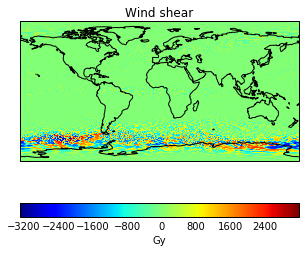

In [8]:
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
plt.figure(figsize=(5,5))


qplt.pcolormesh(shear[0,0,0,30])

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()



## Create an annotatable plot

In [9]:
import holoviews as hv
import geoviews as gv
hv.extension('bokeh')

ImportError: None of the backends could be imported

In [14]:
# convert cube to gv.Dataset
# OR
# def interactive_contourf()
# ???

def interactive_contourf(cube):
    # Return an interactive GeoViews FilledContours object
    dataset = gv.Dataset(cube, [coord.name() for coord in cube.dim_coords])
    contourf = gv.FilledContours(dataset).opts(line_color=None, line_width=0)
    return contourf

In [16]:
# create plot and coastlines

shear_plot = interactive_contourf(shear)
coastlines = gv.feature.coastline

DataError: None of the available storage backends were able to support the supplied data format.

In [12]:
# create warning annotation tools

from holoviews.streams import FreehandDraw

warning_orange = gv.Polygons([]).opts(line_color='orange', line_width=9, 
                                      fill_color='orange', fill_alpha=0.6)
warning_orange_tool = FreehandDraw(source=warning_orange)

ValueError: Unexpected option 'line_color' for Polygons type across all extensions. Similar options for current extension ('matplotlib') are: ['clipping_colors', 'color', 'ecolor'].

In [13]:
# combine layers into single plot

shear_interactive = shear_plot * coastlines * warning_orange
shear_interactive

NameError: name 'shear_plot' is not defined

## Annotate plot

In [ ]:
# define function to serve up as app

def make_annotable(plot, port=0, websocket_origin='pangeo.informaticslab.co.uk', url_path='annotable'):
    import holoviews as hv
    from bokeh.server.server import Server
    import os
    from IPython.core.display import display, HTML
    import ipywidgets as widgets
    import qrcode
    
    renderer = hv.renderer('bokeh')
    app = renderer.app(plot)
    server = Server({f'/{url_path}': app}, port=port, allow_websocket_origin=[websocket_origin])
    
    server.start()
    
    prefix = os.environ['JUPYTERHUB_SERVICE_PREFIX']
    url = f"https://{websocket_origin}{prefix}proxy/{server.port}/{url_path}"
    display(HTML(f'<a href={url}>{url}</a>'))
    display(qrcode.make(url))
    
    stop_button = widgets.Button(description=f"Stop {url_path}")
    stop_button.on_click(lambda b: server.stop())
    display(stop_button)
    
    return server

In [ ]:
# annotate on phone/ipad

make_annotable(shear_interactive)

In [ ]:
# access annotations directly in notebook

warning_orange_tool.element()

In [ ]:
warning_orange_tool.element().data

## Publish warning as document/website

In [ ]:
# ???